In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys

from RBM import RBM
from scipy.integrate import simps
from scipy import stats


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

data = np.genfromtxt('../data/data_1d2c_bal_seed14.dat')
data = torch.tensor((data+1)/2, device=device, dtype=dtype)


lr = 0.01
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 600
Nh = 20
Nv = data.shape[1]
ep_max = 100
w_hat = torch.linspace(0, 1, steps=100)
_, _, V = torch.svd(data)
V = V[:, 0]
N = 20000
it_mean = 50
fq_msr_RBM = 1000

myRBM = RBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            w_hat=w_hat,
            N=N,
            it_mean=it_mean,
            V=V,
            TMCLearning=True
            )

myRBM_norm = RBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            w_hat=w_hat,
            N=N,
            it_mean=it_mean,
            V=V,
            TMCLearning=False
            )

In [2]:
vinit = torch.bernoulli(torch.rand(
        (myRBM_norm.Nv, 1000), device=myRBM_norm.device, dtype=myRBM_norm.dtype))
si, _, _, _ = myRBM_norm.Sampling(vinit, it_mcmc=10000)


In [8]:
nb_chain = 15  # Nb de chaines pour chaque w_hat
it_mcmc = 25  # Nb it_mcmc pour chaque chaine
it_mean = 10  # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000  # Contrainte
nb_point = 1000  # Nb de points de discrétisation pour w_hat
start = torch.bernoulli(torch.rand(
    Nv, nb_chain*nb_point, device=device))
# SVD des poids
_, _, V0 = torch.svd(myRBM.W)
V0 = V0[:, 0]
# proj_data = torch.mv(X.T, V0)
# xmin = torch.min(proj_data)
if torch.mean(V0) < 0:
    V0 = -V0
xmin = -0.5
xmax = 1
w_hat_b = torch.linspace(
    xmin, xmax, steps=nb_point, device=device)
w_hat = torch.zeros(nb_chain*nb_point, device=device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[i*nb_chain+j] = w_hat_b[i]
tmpv, tmph, vtab = myRBM.TMCSample(
    start, w_hat, N, V0, it_mcmc=it_mcmc, it_mean=it_mean)
y = np.array(torch.mm(vtab.T, V0.unsqueeze(1)
                      ).cpu().squeeze())/Nv**0.5
newy = np.array([np.mean(y[i*nb_chain:i*nb_chain+nb_chain])
                 for i in range(nb_point)])
w_hat = w_hat.cpu().numpy()
w_hat_b_np = w_hat_b.cpu().numpy()
res = np.zeros(len(w_hat_b)-1)
for i in range(1, len(w_hat_b)):
    res[i-1] = simps(newy[:i]-w_hat_b_np[:i], w_hat_b_np[:i])
const = simps(np.exp(N*res-np.max(N*res)), w_hat_b_np[:-1])
p_m = torch.tensor(np.exp(N*res-np.max(N*res)) /
                   const, device=myRBM.device)
s_i = torch.stack([torch.mean(
    tmpv[:, i*nb_chain:i*nb_chain+nb_chain], dim=1) for i in range(nb_point)], 1)
tau_a = torch.stack([torch.mean(
    tmph[:, i*nb_chain:i*nb_chain+nb_chain], dim=1) for i in range(nb_point)], 1)
s_i = torch.trapz(s_i[:, 1:]*p_m, w_hat_b[1:], dim=1)
tau_a = torch.trapz(tau_a[:, 1:]*p_m, w_hat_b[1:], dim=1)

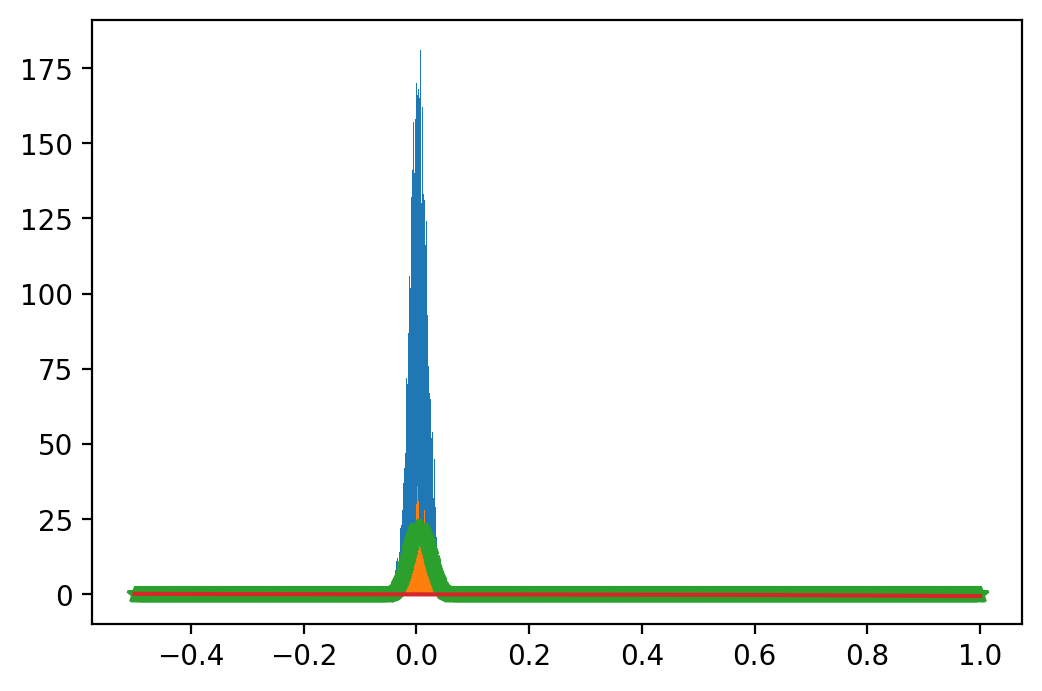

In [9]:
_, _, V_g = torch.svd(myRBM.W)
if torch.mean(V_g[:,0])<0:
    V_g = -V_g
proj_gen = torch.mv(si, V_g[:,0])/Nv**0.5
plt.figure(dpi = 200)
proj_data = torch.mv(data, V_g[:,0])/Nv**0.5
#proj_data = (proj_data-min(proj_data))/(max(proj_data)-min(proj_data))
plt.hist(proj_data.cpu().numpy(), bins = 100);
plt.hist(proj_gen.cpu().numpy(), bins = 100);
plt.plot(w_hat_b.cpu().numpy()[1:],p_m.cpu().numpy(), '-*')
plt.plot(w_hat_b.cpu().numpy(),newy-w_hat_b.cpu().numpy())
#plt.semilogy()

In [10]:
myRBM_norm.fit(data.T, 1)

IT  0
